# Analyse des données textuelles

À partir des données l'application [Yelp](https://www.yelp.fr), traiter les sujets d'insatisfaction dans les commentaires client.

**Analyser les commentaires pour détecter les différents sujets d’insatisfaction**
 - **pré-traitement des données textuelles**
 - utilisation de techniques de réduction de dimension
 - visualisation des données de grandes dimensions

**Collecter un échantillon (environ 200 restaurants) de données via l’API Yelp**
 - récupérer uniquement les champs nécessaires
 - stocker les résultats dans un fichier exploitable (par exemple csv)


# Chargement des biblothèques

In [1]:
import pandas as pd
from wordcloud import WordCloud

In [2]:
# Nécessaire lors de la phase de développement pour mettre à jour la classe olist dans le notebook
%load_ext autoreload
%autoreload 2

In [3]:
# Chargement des bibliothèques
data_dir = '../data/'
from Extract import Extract
extract = Extract()

# Partie 1 -  Pré-traitement des données textuelles

Le pré-traitement consiste à nettoyer les données avant de les soumettre au modèle.

**Pré-traitement de données**

Les données de Yelp sont ditributées dans différents fichiers, nous utiliserons les fichiers **yelp_academic_dataset_business.json** et **yelp_academic_dataset_review.json**.

Dans le fichier **yelp_academic_dataset_business.json** nous garderons les catégories des établissements pour filtrer par rapport aux "Restaurants".
"text", qui est le texte du commentaire et "stars" qui est la note attribuée par le client.
```json
{
    "review_id":"string,
    "user_id":"string",
    "business_id":"string",
    "stars":float,
    "useful":integer,
    "funny":integer,
    "cool":integer,
    "text":"string",
    "date":"datetime"
}
```


Dans  le fichier  **yelp_academic_dataset_business.json**, après avoir fait le lien avec les établissements nous ne retiendrons que colonnes "text", qui est le texte du commentaire et "stars" qui est la note attribuée par le client.
```json
{
  "business_id": "tXvdYGvlEceDljN8gt2_3Q",
  "name": "Capital City Barber Shop",
  "address": "615 W Slaughter Ln, Ste 113",
  "city": "Austin",
  "state": "TX",
  "postal_code": "78748",
  "latitude": 30.1727062,
  "longitude": -97.7999199,
  "stars": 4.0,
  "review_count": 5,
  "is_open": 0,
  "attributes": {
    "BusinessAcceptsCreditCards": "False",
    "RestaurantsPriceRange2": "3",
    "ByAppointmentOnly": "False",
    "BusinessParking": 
      {
          'garage': False,
          'street': False,
          'validated': False,
          'lot': False,
          'valet': False
      }
  },
  "categories": "Barbers, Beauty & Spas",
  "hours": {
    "Monday": "9:0-17:0",
    "Tuesday": "9:0-19:0",
    "Wednesday": "9:0-19:0",
    "Thursday": "9:0-19:0",
    "Friday": "9:0-19:0",
    "Saturday": "9:0-16:0"
  }
}

```

## Chargement des données et premier traitement des textes

Ce pré-traitement des données s'effectue en 7 étapes : 
 1. Chargement du fichier des établissement
 2. Chargement du fichier des commentaires
 3. Supression des Retour chariot dans le commentaires, pour que les commentaires soient sur une seule ligne
 4. Regroupenet des 2 jeux de données
 5. Sélection des établissements qui sont un restaurant. C'est à dire qui sont dans la catégorie "Restaurants"
 6. Sélection des commentaires qui ont entre 0 et 2 étoiles.
 7. Création d'un nouveau jeu de données

In [4]:
# Attention ce traitement peut-être très long en fonction de l'environement d'execution 
#extract.clean_yelp(data_dir, data_dir + 'raw_clean_review.csv')

## Nettoyage des données
Le fichier précedement traité va être de nouveau chargé afin de préparer les commentaires en vue du traitement par les modèles.

Les informations qui seront utilisées sont **stars** et  **text**. Le champ **stars** est la note entre 0 et 5 donnée par le client. Nous avons considéré qu'une note entre 0 et 2 est une mauvaise note, donc un sujet d'insatisfaction et les notes entre 3 et 5 comme de bonnes notes. Nous avons créé une colonne **bad_review**, pour indiquer si oui ou non le commentaire est un sujet d'instisfaction.

Traitements effectués

 - Chargement du dataset en lot
 - Sélection des colonnes
 - Mise en minuscule du texte
 - Supression des acccents
 - Expension des contractions
 - Suppression de la ponctuation
 - Suppression des mots qui contiennent des chiffres
 - Lemmatization
 - Stopwords

In [27]:
# Attention ce traitement peut-être très long en fonction de l'environement d'execution 

df_raw = pd.read_csv(data_dir + 'raw_clean_reviews.csv')
extract.clean_file(data_dir + 'raw_clean_reviews.csv', data_dir + 'clean_reviews.csv')

100% (2253 of 2253) |####################| Elapsed Time: 0:19:57 ETA:  00:00:00

In [17]:
data = extract.load_dataset(data_dir + 'clean_reviews.csv')

In [18]:
data.shape

(1126980, 4)

# Génération des fichiers pour les modèles
Génération de deux fichiers pour l'entrainement des modèle. Cela va permettre de comparer les même données en entrée des modèles

In [6]:
data = extract.load_dataset(data_dir + 'clean_reviews.csv')
data = data.sample(60010)

test = data.sample(10)
test.to_csv(data_dir + 'test_reviews.csv')

df = data.drop(test.index)
df.to_csv(data_dir + 'train_reviews.csv')

In [7]:
data.shape

(60010, 4)

# Visualisation des mots

In [8]:
import pandas as pd
from wordcloud import WordCloud

In [9]:
df = extract.load_dataset(data_dir + 'clean_reviews.csv')

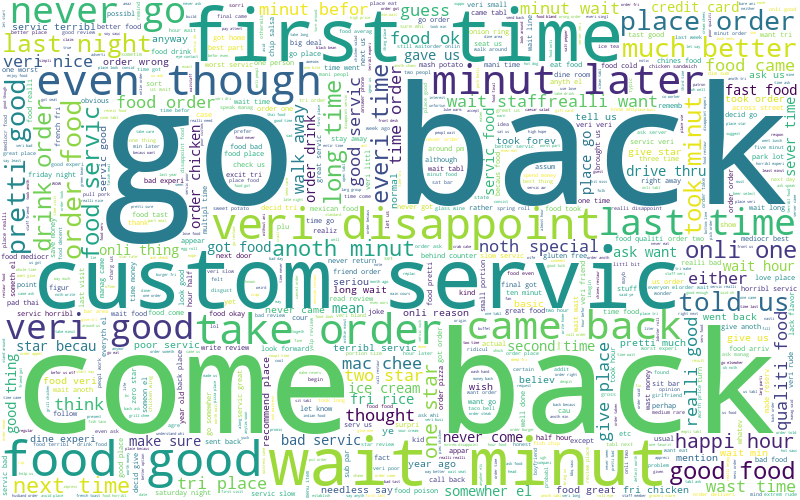

In [10]:
all_words = ' '.join(list(df['clean_text']))
wordcloud = WordCloud(
    background_color="white", 
    max_words=5000, 
    contour_width=3, 
    contour_color='steelblue',
    width=800,
    height=500)
wordcloud.generate(all_words)
wordcloud.to_image()

In [11]:
wordcloud.to_file('img/wordcloud.png')

## Exemple avec l'expression "come back"

In [12]:
pd.options.display.max_colwidth = 1000

In [13]:
df[df['text'].str.contains('come back')]['text'].loc[174]

"They have a lot of options to choose from. The inside is nice and roomy. The food is not that good nor does the food seem fresh. I wouldn't come back."

## Exemple avec l'expression "go back"

In [14]:
df[df['text'].str.contains('go back')]['text'].loc[225]

'Good tapas but not that cheap. Excellent service.  Weakest drinks in Atlanta! Do NOT order an overpriced mixed drink. My buddy & I spent over $60 each on mixed drinks and what a waste. I will go back but will only order bottled beer. I recommend you do the same.......'

## Exemple avec l'expression "customer service"

In [15]:
df[df['text'].str.contains('customer service')]['text'].head(1)

13    I was so blown away how rude the staff was. I think they forgot the meaning of customer service!! Very disappointing as they are the gateway to visitors I wouldn't go there again. This is the spot outside of security
Name: text, dtype: object

# Conclusion

Cette première étape est obligatoire et nécessaire fin d'avoir un jeu de données le plus épuré possible, afin de ne retenir que les mots essentiels.

Les mots ou expression qui ressortent le plus concernant l'insatisfaction sont : 
 - come back (revenir)
 - go back (retourner)
 - customer service (service client)
 
Cette première approche ne nous permet pas de catégoriser les sujets d'insastifactions car les deux premières expressions qui apparaissent le plus souvent invite le consomateur à ne plus revenir dans le restaurant, sans que l'on sache pourquoi.

Les prochaines étapes vont nous permettre de détecter plus finement les sujets d'insatisfactions.
 